In [1]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
sys.path.append('../')
from Dataset_Creation import sys_dataset
import Dataset_load 

In [2]:
figformat = 'png'

In [3]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [4]:

scale  = 0.05
scaled_amplitude = Parameter('amplitude',
                             value = 4.11e-11 * scale)
dataset_asimov  = Dataset_load.create_asimov(model = 'ecpl', source = "PKSflare",
                                            parameters = Parameters([scaled_amplitude]))

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-ecpl.fits.gz


In [5]:
edispKernelMap = dataset_asimov.edisp
edispKernel = edispKernelMap.get_edisp_kernel()
edispMap = edispKernelMap.edisp_map
energy_axis = edispKernel.axes["energy"]

In [34]:
emask = dataset_asimov.mask.data.sum(axis=2).sum(axis=1)>0
#thr = 1*u.TeV
emask_center= dataset_asimov.geoms['geom'].axes[0].center[emask]
edges_masked = dataset_asimov.geoms['geom'].axes[0].edges[len(emask_center):]

energy = edispKernel.axes['energy']#.from_edges(edispKernel.axes['energy'].edges[emask],
                                            #  name = "energy")
energy_true = edispKernel.axes['energy_true']#.from_edges(edispKernel.axes['energy_true'].edges[emask],
                                                 #       name = "energy_true")
print(energy_true)
edispKerneldata = edispKernel.data#[len(emask_center)- sum(emask_center):,len(emask_center)- sum(emask_center):]

MapAxis

	name       : energy_true
	unit       : 'TeV'     
	nbins      : 24        
	node type  : edges     
	edges min  : 1.0e-01 TeV
	edges max  : 1.0e+02 TeV
	interp     : log       



In [24]:
from astropy.visualization import quantity_support

def plot(edispKernel_, ax=None, label_true_energy = True):
    ax = plt.gca() if ax is None else ax
    kwargs =dict()
    kwargs.setdefault("cmap", "GnBu")
    from matplotlib.colors import PowerNorm

    norm = PowerNorm(gamma=0.5, vmin=0, vmax=1)
    kwargs.setdefault("norm", norm)


    energy_axis = energy
    if label_true_energy:
        energy_axis_true_ = energy_true
    else:
        energy_axis_true_ = energy
    with quantity_support():
        caxes = ax.pcolormesh(
            energy_axis_true_.edges, 
            energy_axis.edges, 
            edispKernel_, **kwargs
        )

    label = "Probability density (A.U.)"
    ax.figure.colorbar(caxes, ax=ax, label=label)

    energy_axis_true_.format_plot_xaxis(ax=ax)
    energy_axis.format_plot_yaxis(ax=ax)
    ax.loglog()
    return ax

(24, 24)


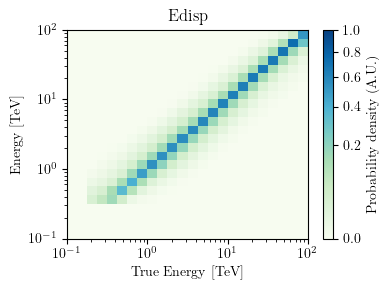

In [25]:
fig, ax = plt.subplots(figsize = (4,3))
plot(edispKerneldata.T,ax)
ax.set_title(f'Edisp')
print(edispKernel.data.shape)
plt.tight_layout()
fig.savefig("plots/2-Edisp_example."+figformat)

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


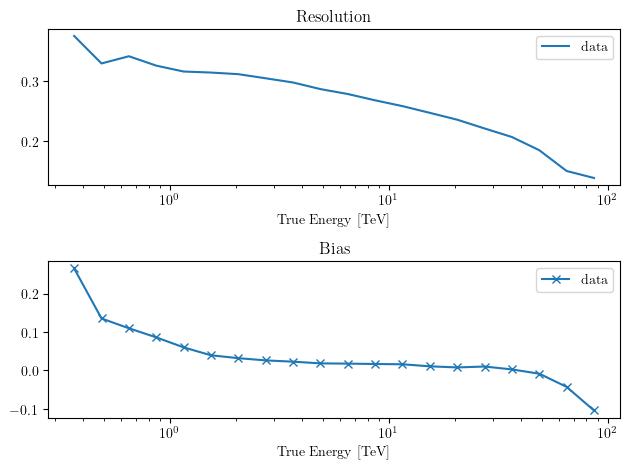

In [51]:
fig, axs = plt.subplots(2,1)

axs[0].plot(emask_center.value, edispKernel.get_resolution(energy.center)[emask], label = 'data')
axs[0].legend()
axs[0].set_xscale('log')
axs[0].set_title("Resolution")
axs[0].set_xlabel('True Energy [TeV]')


plt.plot(emask_center.value, edispKernel.get_bias(energy.center)[emask], label = 'data', marker = 'x')
plt.legend()
plt.xscale('log')
plt.title("Bias")
plt.xlabel('True Energy [TeV]')
plt.tight_layout()
fig.savefig("plots/2-Edisp_res_bias.svg")

In [37]:
from gammapy.maps import MapAxis
from gammapy.irf import EDispKernel, EDispKernelMap
def get_gaussian_kernel(bias, sigma, energy = energy):
    edisp_kernel = EDispKernel.from_gauss(
        energy_axis_true=energy.copy(name = "energy_true"), 
        energy_axis=energy,
        sigma=1e-12+sigma,
        bias=bias
    )
    return edisp_kernel

(24, 24)


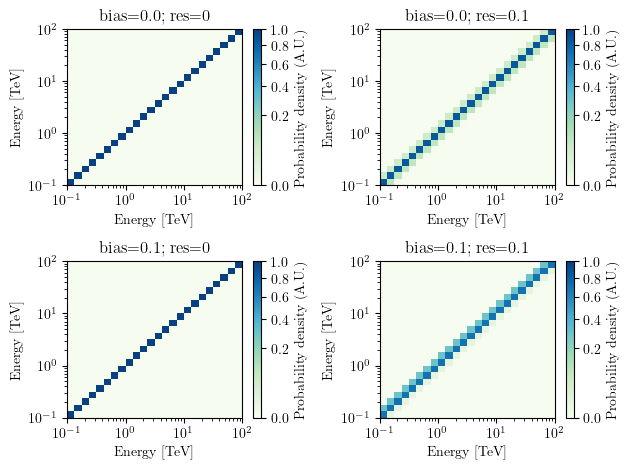

In [38]:


fig, axs = plt.subplots(2,2)
axs = axs.flatten()
delta = 1e-2
biass = [0.0, 0.1]
sigmass = [0, 0.1, ]
#sigmass = [0.01, 0.02, 0.03, 0.04]
gaussians = []
i = 0

for b in biass:
    for s in sigmass:
        gaussian = get_gaussian_kernel(bias = b, sigma = s)
        gaussians.append(gaussian)
        plot(gaussian.data.T,axs[i], False)
        axs[i].set_title(f'bias={b}; res={s}')
        i +=1

print(gaussian.data.shape)
plt.tight_layout()



/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


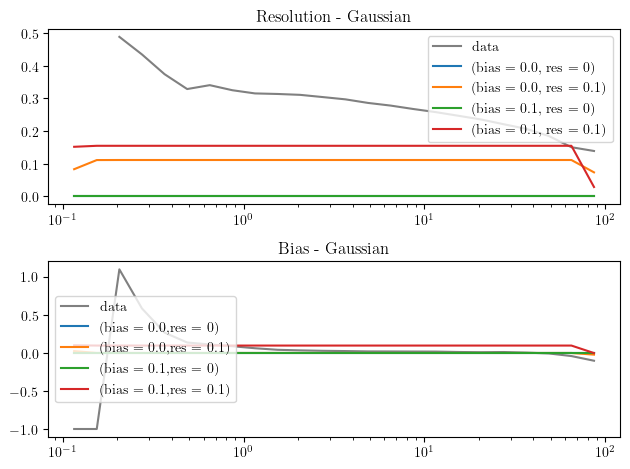

In [39]:
fig, axs = plt.subplots(2,1)

axs[0].plot(energy.center.value, edispKernel.get_resolution(energy.center), label = 'data',
           color = 'grey')
i =0 
for b in biass:
    for s in sigmass:
        axs[0].plot(energy.center.value, gaussians[i].get_resolution(energy.center), label =f"(bias = {b}, res = {s})")
        i += 1
    
axs[0].legend()
axs[0].set_xscale('log')
axs[0].set_title("Resolution - Gaussian")


plt.plot(energy.center.value, edispKernel.get_bias(energy.center), label = 'data',
        color = 'grey')
i =0 
for b in biass:
    for s in sigmass:
        plt.plot(energy.center.value, gaussians[i].get_bias(energy.center), label = f"(bias = {b},res =  {s})")
        i += 1
plt.legend()
plt.xscale('log')
plt.title("Bias - Gaussian")
plt.tight_layout()


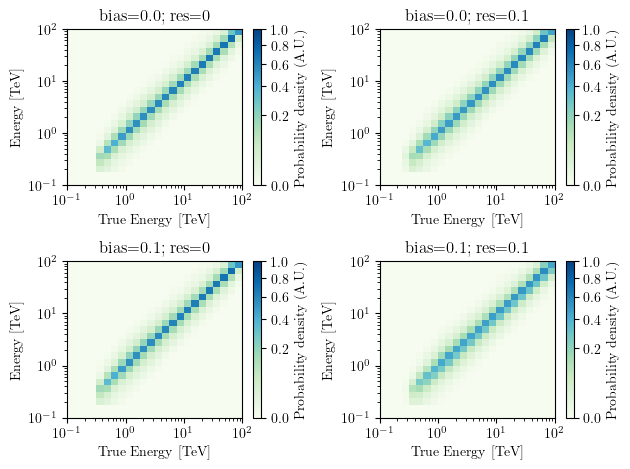

In [55]:
convs = []
fig, axs = plt.subplots(2,2)
axs = axs.flatten()

i = 0

for b in biass:
    for s in sigmass:
        gaussian = get_gaussian_kernel(bias = b, sigma = s)
        conv = EDispKernel(
         axes = edispKernel.axes,
         data = np.matmul(edispKerneldata, gaussian.data)
        )
        
        plot(conv.data,axs[i])
        axs[i].set_title(f'bias={b}; res={s}')
        i +=1
        convs.append(conv)
        
plt.tight_layout()

fig = plt.gcf()
fig.savefig("plots/1-matrices."+figformat)

In [62]:
gaussian = get_gaussian_kernel(bias = 0.1, sigma = 0)
conv_test = EDispKernel(
 axes = edispKernel.axes,
 data = np.matmul(edispKerneldata, gaussian.data)
)

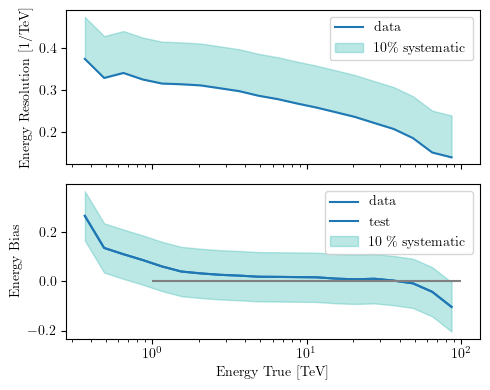

In [63]:
fig, axs = plt.subplots(2,1, sharex=True, figsize = (5,4))

axs[0].plot(energy.center.value[emask], edispKernel.get_resolution(energy.center[emask]), label = 'data',
           color = 'tab:blue')

axs[0].fill_between(energy.center.value[emask], 
            edispKernel.get_resolution(energy.center[emask]) , 
            edispKernel.get_resolution(energy.center[emask]) +0.1
            , label = '10\% systematic', alpha = 0.3, 
           color = 'lightseagreen'      )

axs[0].legend()
axs[0].set_xscale('log')

plt.plot(energy.center.value[emask], edispKernel.get_bias(energy.center[emask]), label = 'data',
        color = 'tab:blue')

plt.plot(energy.center.value[emask], conv_test.get_bias(energy.center[emask]), label = 'test',
        color = 'tab:blue')

plt.fill_between(energy.center.value[emask], edispKernel.get_bias(energy.center[emask]) -0.1,
                 edispKernel.get_bias(energy.center[emask]) +0.1, label = '10 \% systematic',
        color = 'lightseagreen', alpha = 0.3)

axs[1].hlines(0, 1,100,  color = 'grey')
plt.legend()

plt.xscale('log')
plt.ylabel("Energy Bias")
axs[0].set_ylabel("Energy Resolution [1/TeV]")

plt.xlabel("Energy True [TeV]")
plt.tight_layout()

fig = plt.gcf()
fig.savefig('plots/1-bias-res-sys' + figformat)

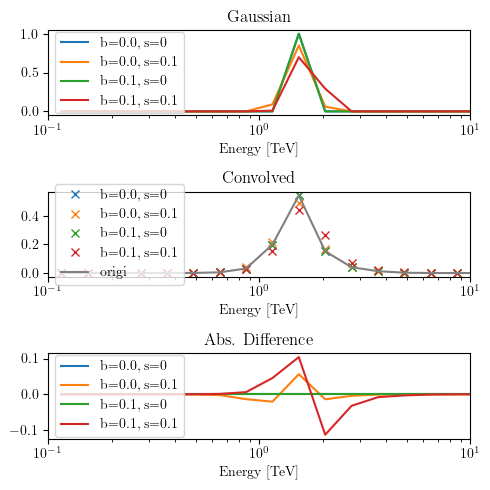

In [44]:
fig, axs = plt.subplots(3,1, figsize = (5,5))
idx = 9
for b in biass:
    for s in sigmass:
        gaussian = get_gaussian_kernel(bias = b, sigma = s)
        conv = EDispKernel( axes = edispKernel.axes,  data = np.matmul(edispKernel.data, gaussian.data))
        axs[0].plot(energy.center, gaussian.data[idx,:], label = f'b={b}, s={s}')
        axs[2].plot(energy.center , edispKernel.data[idx,:]-conv.data[idx,:], label = f'b={b}, s={s}')
        axs[1].plot(energy.center , conv.data[idx,:], 'x', label = f'b={b}, s={s}')
        
axs[1].plot(energy.center ,edispKernel.data[idx,:], label = 'origi', color = 'grey')
axs[0].set_title("Gaussian")
axs[1].set_title("Convolved")
axs[2].set_title("Abs. Difference")



for a in axs:
    a.legend(loc = 'center left')
    a.set_xlabel("Energy [TeV]")
    a.set_xscale('log')
    a.set_xlim(0.1, 10)
    
plt.tight_layout()

In [45]:
widths = (energy.edges[1:] - energy.edges[:-1]) * 0.5

conv_data = conv.data[idx,:] 
n_bins = 10
idx = 9
conv_rebins = np.repeat(conv_data, n_bins)
energy_rebins = MapAxis(nodes =np.logspace(np.log10(energy.edges[0].value), 
                                           np.log10(energy.edges[-1].value),
                                           n_bins *len(energy.center)),
                        node_type='center',
                        name = 'energy',
                       unit = 'TeV')

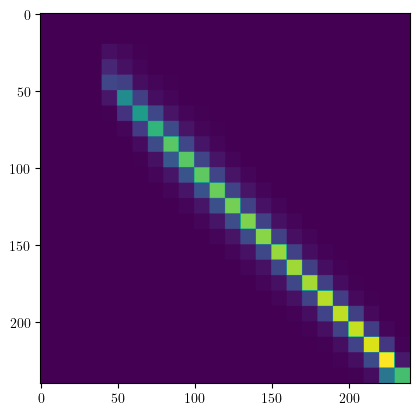

In [46]:
edispKernel_re = EDispKernel( axes = [energy_rebins.copy(name = 'energy_true'), energy_rebins] , 
                   data = np.repeat(np.repeat(edispKernel.data, n_bins,axis =0), n_bins, axis =1))
plt.imshow(edispKernel_re.data)

Text(0.5, 0, 'Energy [TeV]')

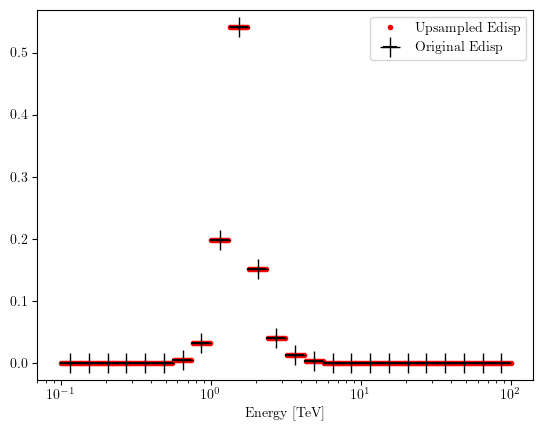

In [47]:
plt.plot(energy_rebins.center, edispKernel_re.data[idx * n_bins],'.',label= "Upsampled Edisp",
        color = 'red')
plt.errorbar(energy.center, edispKernel.data[idx],
            xerr =widths, fmt='+',  label = 'Original Edisp', color = 'black',markersize = 14)
plt.xscale('log')
plt.legend()
plt.xlabel("Energy [TeV]")


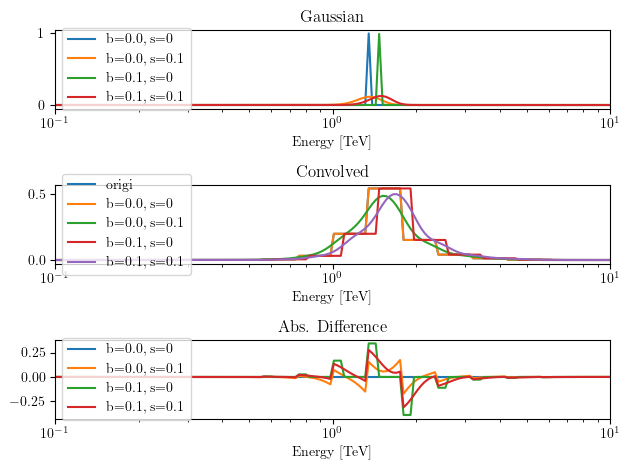

In [48]:
fig, axs = plt.subplots(3,1)
idx_re = idx * n_bins
axs[1].plot(energy_rebins.center ,edispKernel_re.data[idx_re,:], label = 'origi')
for b in biass:
    for s in sigmass:
        gaussian = get_gaussian_kernel(bias = b, sigma = s,
                                      energy = energy_rebins)
        conv = EDispKernel( axes = edispKernel_re.axes,  data = np.matmul(edispKernel_re.data, gaussian.data))
        axs[0].plot(energy_rebins.center, gaussian.data[idx_re,:], label = f'b={b}, s={s}')
        axs[1].plot(energy_rebins.center , conv.data[idx_re,:],  label = f'b={b}, s={s}')
        axs[2].plot(energy_rebins.center , edispKernel_re.data[idx_re,:]-conv.data[idx_re,:], label = f'b={b}, s={s}')
        
axs[0].set_title("Gaussian")
axs[1].set_title("Convolved")
axs[2].set_title("Abs. Difference")

for a in axs:
    a.legend(loc = 'center left')
    a.set_xlabel("Energy [TeV]")
    a.set_xscale('log')
    a.set_xlim(0.1, 10)
    
plt.tight_layout()

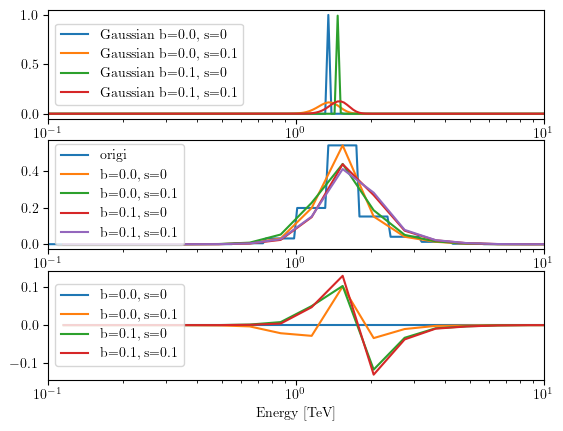

In [49]:
fig, axs = plt.subplots(3,1)
axs[1].plot(energy_rebins.center ,edispKernel_re.data[idx_re,:], label = 'origi')
for b in biass:
    for s in sigmass:
        gaussian = get_gaussian_kernel(bias = b, sigma = s,
                                      energy = energy_rebins)
        conv = EDispKernel( axes = edispKernel_re.axes,  data = np.matmul(edispKernel_re.data, gaussian.data))
        axs[0].plot(energy_rebins.center, gaussian.data[idx_re,:], label = f' Gaussian b={b}, s={s}')
        axs[1].plot(energy.center , conv.data[idx_re,:].reshape(-1, n_bins).mean(axis=1),
                    label = f'b={b}, s={s}')
        axs[2].plot(energy.center , edispKernel.data[int(idx),:]-conv.data[idx_re,:].reshape(-1, n_bins).mean(axis=1),
                    label = f'b={b}, s={s}')


for a in axs:
    a.legend(loc = 'center left')
    a.set_xlabel("Energy [TeV]")
    a.set_xscale('log')
    a.set_xlim(0.1, 10)

In [65]:
gaussian = get_gaussian_kernel(bias = 0.1, sigma = 0,
                                  energy = energy_rebins)
conv_test_2 = EDispKernel( axes = edispKernel_re.axes,  data = np.matmul(edispKernel_re.data, gaussian.data))


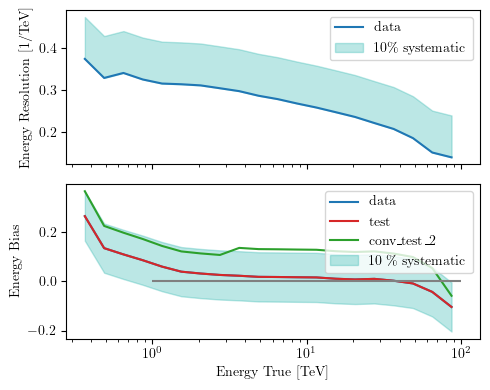

In [66]:
fig, axs = plt.subplots(2,1, sharex=True, figsize = (5,4))

axs[0].plot(energy.center.value[emask], edispKernel.get_resolution(energy.center[emask]), label = 'data',
           color = 'tab:blue')

axs[0].fill_between(energy.center.value[emask], 
            edispKernel.get_resolution(energy.center[emask]) , 
            edispKernel.get_resolution(energy.center[emask]) +0.1
            , label = '10\% systematic', alpha = 0.3, 
           color = 'lightseagreen'      )

axs[0].legend()
axs[0].set_xscale('log')

plt.plot(energy.center.value[emask], edispKernel.get_bias(energy.center[emask]), label = 'data',
        color = 'tab:blue')

plt.plot(energy.center.value[emask], conv_test.get_bias(energy.center[emask]), label = 'test',
        color = 'tab:red')
plt.plot(energy.center.value[emask], conv_test_2.get_bias(energy.center[emask]), label = 'conv_test_2',
        color = 'tab:green')

plt.fill_between(energy.center.value[emask], edispKernel.get_bias(energy.center[emask]) -0.1,
                 edispKernel.get_bias(energy.center[emask]) +0.1, label = '10 \% systematic',
        color = 'lightseagreen', alpha = 0.3)

axs[1].hlines(0, 1,100,  color = 'grey')
plt.legend()

plt.xscale('log')
plt.ylabel("Energy Bias")
axs[0].set_ylabel("Energy Resolution [1/TeV]")

plt.xlabel("Energy True [TeV]")
plt.tight_layout()

fig = plt.gcf()
fig.savefig('plots/1-bias-res-sys' + figformat)